1. Project Overview

In [118]:
"""
This project predicts customer churn for a Spotify-like music streaming service.
It covers the full machine learning lifecycle: data analysis, preprocessing,
imbalance handling, fairness checks, model evaluation, and deployment readiness.
"""

'\nThis project predicts customer churn for a Spotify-like music streaming service.\nIt covers the full machine learning lifecycle: data analysis, preprocessing,\nimbalance handling, fairness checks, model evaluation, and deployment readiness.\n'

2. Business Problem

In [119]:
"""
Customer churn significantly affects subscription-based revenue.
Accurate churn prediction enables proactive retention strategies and fair,
responsible decision-making.
"""

'\nCustomer churn significantly affects subscription-based revenue.\nAccurate churn prediction enables proactive retention strategies and fair,\nresponsible decision-making.\n'

3. Objective

In [120]:
"""
- Detect churn early using behavioral data
- Handle class imbalance correctly
- Compare multiple ML algorithms fairly
- Evaluate performance using robust metrics
- Assess fairness and model complexity
- Prepare the best model for deployment
"""

'\n- Detect churn early using behavioral data\n- Handle class imbalance correctly\n- Compare multiple ML algorithms fairly\n- Evaluate performance using robust metrics\n- Assess fairness and model complexity\n- Prepare the best model for deployment\n'

4. Imports & Configuration

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

from sklearn.metrics import (
precision_score,
recall_score,
f1_score,
accuracy_score,
classification_report,
confusion_matrix,
roc_auc_score,
roc_curve,
precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

5. Dataset Loading & Description

In [122]:
df = pd.read_csv("SpotifyDataset.csv")

In [123]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8077 non-null   int64  
 1   gender                 8077 non-null   object 
 2   age                    7512 non-null   float64
 3   country                7512 non-null   object 
 4   subscription_type      7512 non-null   object 
 5   listening_time         8077 non-null   int64  
 6   songs_played_per_day   7512 non-null   float64
 7   skip_rate              8077 non-null   float64
 8   device_type            7587 non-null   object 
 9   ads_listened_per_week  8077 non-null   int64  
 10  offline_listening      8077 non-null   int64  
 11  is_churned             8077 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 757.3+ KB


In [124]:
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54.0,CA,Free,26,23.0,0.20,Desktop,31,0,1
1,2,Other,33.0,DE,Family,141,62.0,0.34,Web,0,1,0
2,3,Male,38.0,AU,Premium,199,38.0,0.04,Mobile,0,1,0
3,4,Female,22.0,CA,Student,36,NaN,0.31,Mobile,0,1,1
4,5,Other,29.0,US,Family,250,57.0,0.36,Mobile,0,1,0


In [125]:
df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8077.000000,7512.000000,8077.000000,7512.000000,8077.000000,8077.000000,8077.000000,8077.000000
mean,4130.486567,37.667332,153.967191,50.009052,0.300272,6.965953,0.747183,0.544261
std,2397.076157,12.751225,83.983077,28.421372,0.173523,13.638189,0.434654,0.498068
min,1.000000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2056.000000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,4131.000000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,1.000000
75%,6213.000000,49.000000,227.000000,74.000000,0.450000,5.000000,1.000000,1.000000
max,8241.000000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


6. Data Cleaning

6.1 Missing Values

In [126]:
df.isnull().sum()

user_id                    0
gender                     0
age                      565
country                  565
subscription_type        565
listening_time             0
songs_played_per_day     565
skip_rate                  0
device_type              490
ads_listened_per_week      0
offline_listening          0
is_churned                 0
dtype: int64

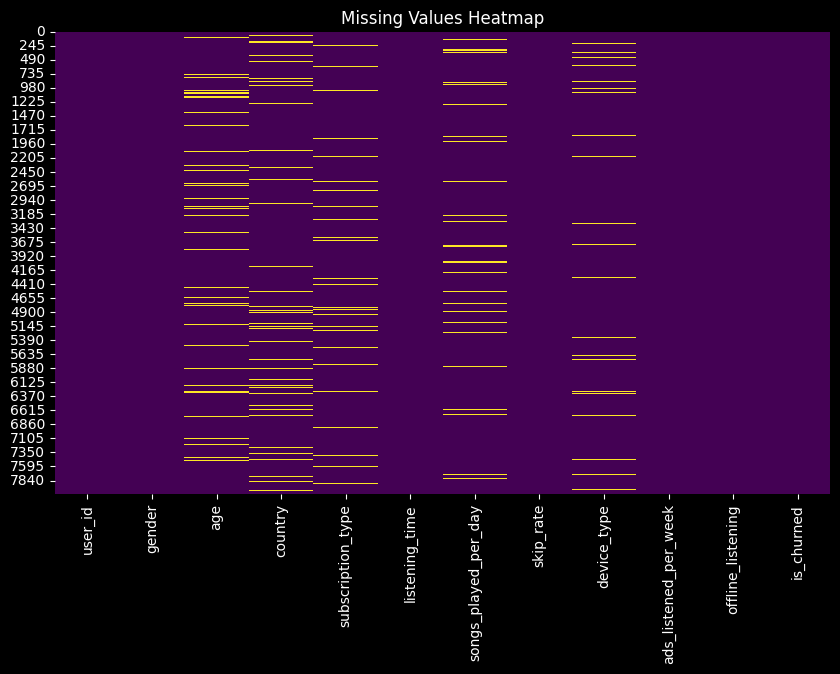

In [127]:
plt.figure(figsize=(10,6))
plt.style.use('dark_background')
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show() 

In [128]:
df.drop(["user_id", "country"], axis=1, inplace=True)


num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns


df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for col in cat_cols:
  df[col].fillna(df[col].mode()[0], inplace=True)

6.2 Duplicates

In [129]:
df.duplicated().sum()

np.int64(45)

In [130]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

6.3 Outliers

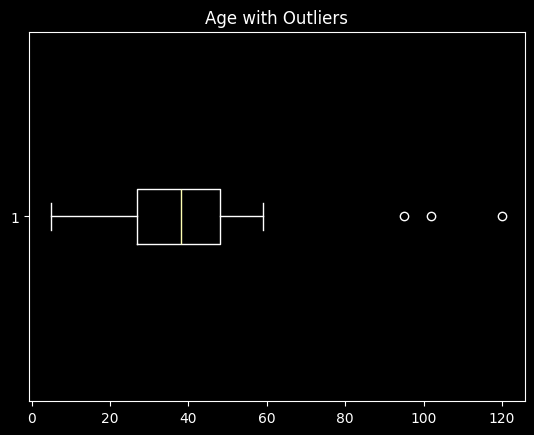

In [131]:
df_outliers = df.copy()
outlier_ages = [5, 95, 102, 120]

# Randomly choose rows to replace
np.random.seed(42)
outlier_indices = np.random.choice(df_outliers.index, size=len(outlier_ages), replace=False)

# Insert outliers
df_outliers.loc[outlier_indices, "age"] = outlier_ages

plt.boxplot(df_outliers["age"], vert=False)
plt.title("Age with Outliers")
plt.show()

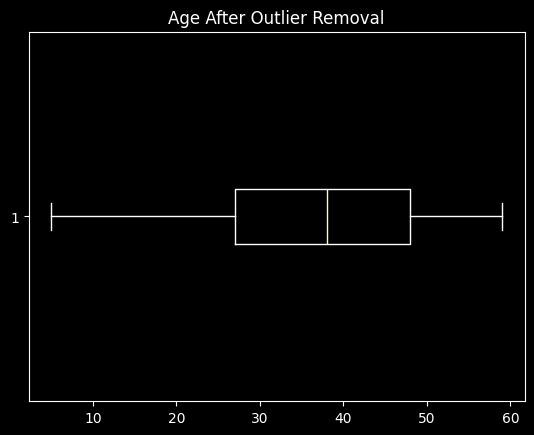

In [132]:
# IQR
Q1 = df_outliers["age"].quantile(0.25)
Q3 = df_outliers["age"].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

df = df_outliers[(df_outliers["age"] >= low) & (df_outliers["age"] <= high)]

plt.boxplot(df["age"], vert=False)
plt.title("Age After Outlier Removal")
plt.show()

7. EDA

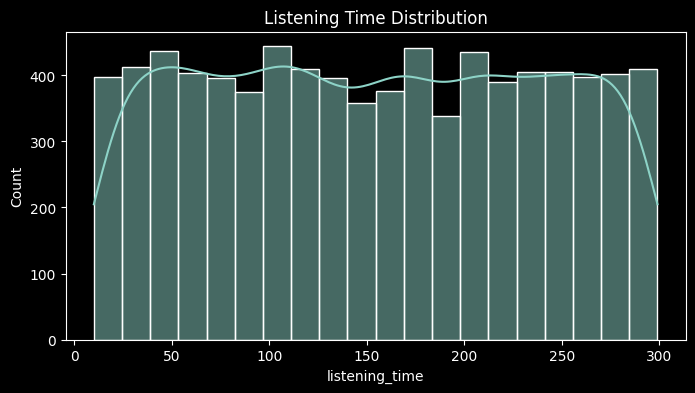

In [133]:
plt.figure(figsize=(8,4))
sns.histplot(df["listening_time"], bins=20, kde=True)
plt.title("Listening Time Distribution")
plt.show()

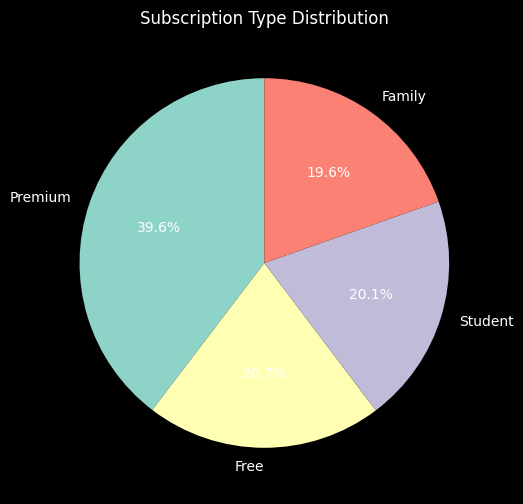

In [134]:
plt.figure(figsize=(6,6))
df["subscription_type"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Subscription Type Distribution")
plt.ylabel("")
plt.show()

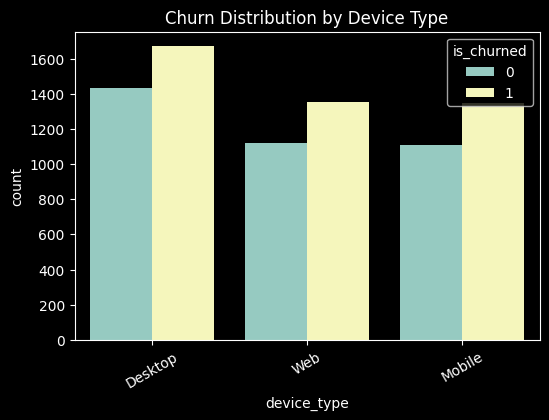

In [135]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x="device_type",
    hue="is_churned"
)
plt.title("Churn Distribution by Device Type")
plt.xticks(rotation=30)
plt.show()

8. Correlation Heatmanp and Chi Square

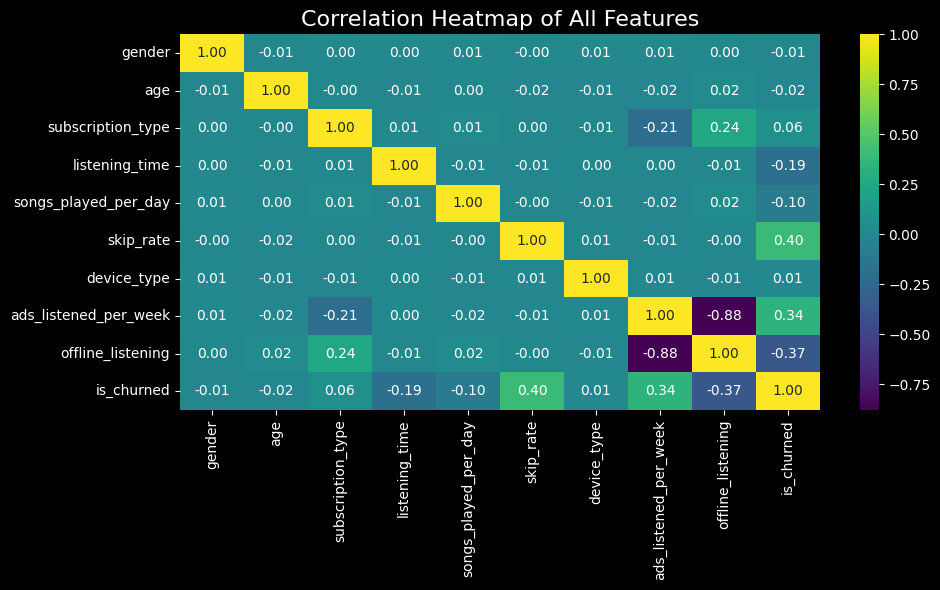

In [136]:
df_corr = df.copy()

# Convert categorical columns to numeric codes
for col in df_corr.select_dtypes(include="object").columns:
    df_corr[col] = df_corr[col].astype("category").cat.codes

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot full correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Correlation Heatmap of All Features", fontsize=16)
plt.tight_layout()
plt.show()


📌 Top Features from Chi-Square:
                 Feature  Chi2 Score        p-value
7  ads_listened_per_week  491.927601  5.424874e-109
8      offline_listening  279.249194   1.094487e-62
5              skip_rate  210.119086   1.293852e-47
3         listening_time   51.592641   6.829710e-13
4   songs_played_per_day   13.273054   2.692482e-04
2      subscription_type    6.066294   1.377857e-02
0                 gender    0.389388   5.326215e-01
1                    age    0.215732   6.423116e-01
6            device_type    0.175058   6.756555e-01


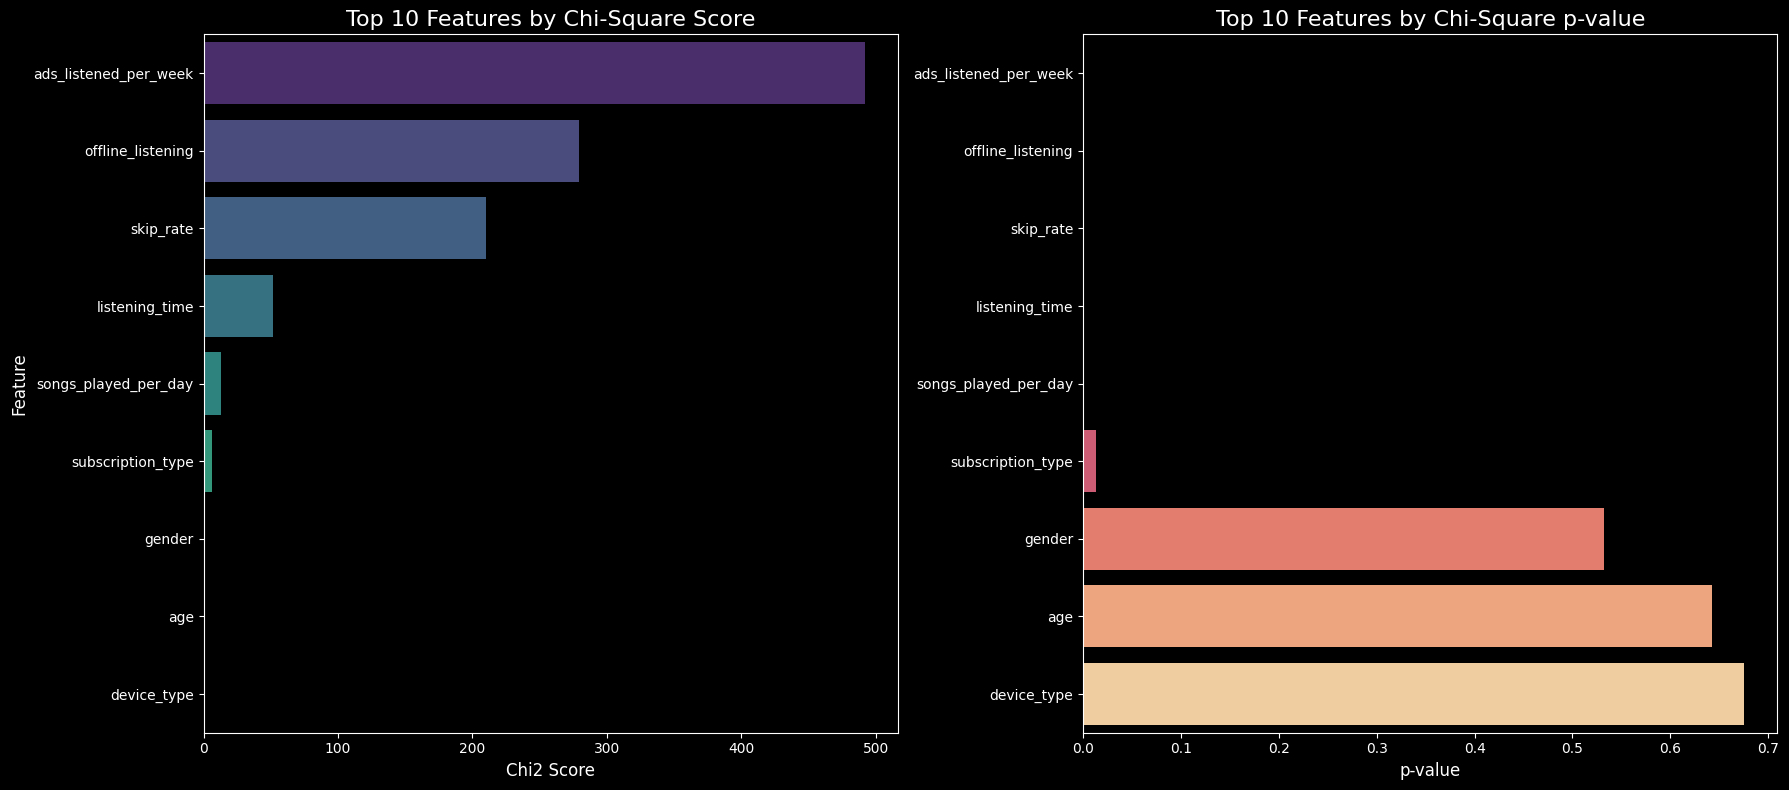

In [137]:
# Copy features
X_chi = df.drop("is_churned", axis=1)
y_chi = df["is_churned"]
# Encode categorical features
for col in X_chi.select_dtypes(include="object").columns:
    X_chi[col] = X_chi[col].astype("category").cat.codes
# Scale features to non-negative range
scaler = MinMaxScaler()
X_chi_scaled = scaler.fit_transform(X_chi)
# Compute chi-square scores
chi_scores, p_values = chi2(X_chi_scaled, y_chi)
chi_df = pd.DataFrame({
    "Feature": X_chi.columns,
    "Chi2 Score": chi_scores,
    "p-value": p_values
}).sort_values(by="Chi2 Score", ascending=False)
print("\n📌 Top Features from Chi-Square:")
print(chi_df.head(10))

# Take top 10 features by Chi2
top10_chi = chi_df.head(10)
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
# ---------------- Chi2 Scores ----------------
sns.barplot(
    x="Chi2 Score", y="Feature", data=top10_chi, 
    palette="viridis", ax=axes[0]
)
axes[0].set_title("Top 10 Features by Chi-Square Score", fontsize=16)
axes[0].set_xlabel("Chi2 Score", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)
# ----------------p-values ----------------
sns.barplot(
    x="p-value", y="Feature", data=top10_chi, 
    palette="magma", ax=axes[1]
)
axes[1].set_title("Top 10 Features by Chi-Square p-value", fontsize=16)
axes[1].set_xlabel("p-value", fontsize=12)
axes[1].set_ylabel("")  # remove redundant y-label
plt.tight_layout()
plt.show()

9. Feature Engineering

In [138]:
df["EngagementScore"] = df["listening_time"] + df["songs_played_per_day"]
df["AdsEngagement"] = df["ads_listened_per_week"] / (df["listening_time"] + 1)
df["PremiumMobile"] = ((df["subscription_type"] == "Premium") &
(df["device_type"] == "Mobile")).astype(int)

In [139]:
behavioral_features = [
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week",
    "offline_listening",
    "subscription_type",
    "device_type",
    "EngagementScore",
    "AdsEngagement",
    "PremiumMobile"
]


10. Train-Test Split

In [140]:
X = df[behavioral_features]
y = df["is_churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


11. Class Imbalance Check

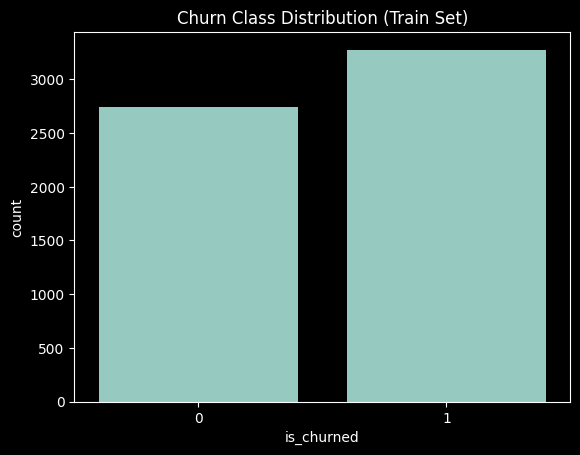

is_churned
1    0.544262
0    0.455738
Name: proportion, dtype: float64


In [141]:
plt.figure()
sns.countplot(x=y_train)
plt.title("Churn Class Distribution (Train Set)")
plt.show()


imbalance_ratio = y_train.value_counts(normalize=True)
print(imbalance_ratio)

12. Preprocessing

In [142]:
num_features = [
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week",
    "offline_listening",
    "EngagementScore",
    "AdsEngagement",
    "PremiumMobile"
]

cat_features = [
    "subscription_type",
    "device_type"
]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])
smote = SMOTE(random_state=42)

13. Training + Complexity

In [143]:
def evaluate_model(name, pipeline):
    tracemalloc.start()
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    pred_time = time.time() - start_pred

    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc,
        "Training Time (s)": train_time,
        "Prediction Time (s)": pred_time,
        "Peak Memory (MB)": peak_memory / (1024 ** 2),
        "Pipeline": pipeline,
        "ROC": (fpr, tpr)
    }


14. Models

14.1 Logistic Regression


Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       915
           1       0.89      0.87      0.88      1093

    accuracy                           0.87      2008
   macro avg       0.87      0.87      0.87      2008
weighted avg       0.87      0.87      0.87      2008



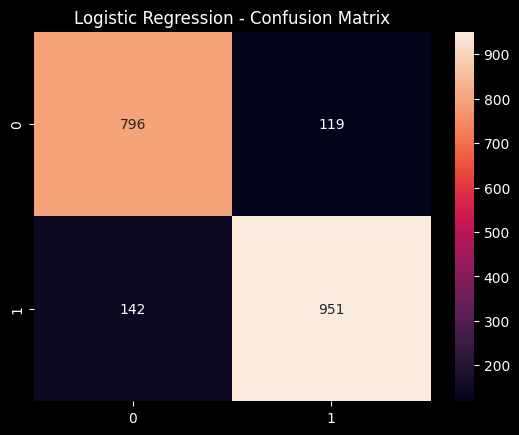

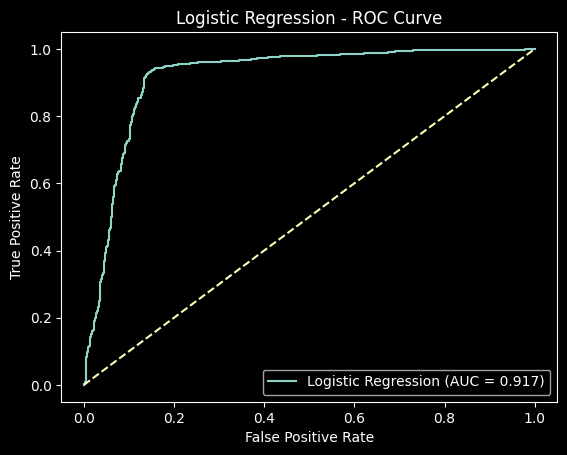

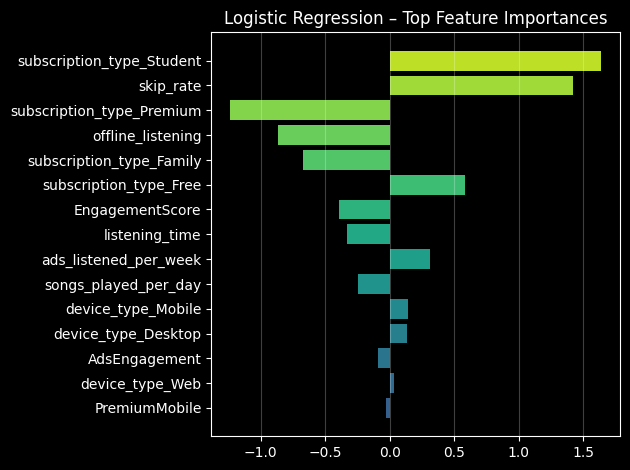

In [144]:
lr_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

lr_results = evaluate_model("Logistic Regression", lr_pipeline)


coef = lr_pipeline.named_steps["model"].coef_[0]
feat = lr_pipeline.named_steps["preprocessor"].get_feature_names_out()

imp = (
    pd.Series(coef, index=feat)
    .rename(lambda x: x.split("__")[-1])
    .sort_values(key=abs)
    .tail(15)
)

plt.style.use("dark_background")
plt.barh(imp.index, imp.values,
         color=plt.cm.viridis(np.linspace(0.3, 0.9, len(imp))))
plt.title("Logistic Regression – Top Feature Importances")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

14.2 Decision Tree


Decision Tree
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       915
           1       0.83      0.80      0.82      1093

    accuracy                           0.80      2008
   macro avg       0.80      0.80      0.80      2008
weighted avg       0.80      0.80      0.80      2008



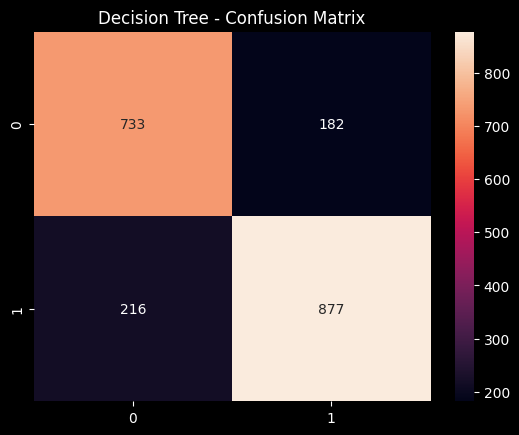

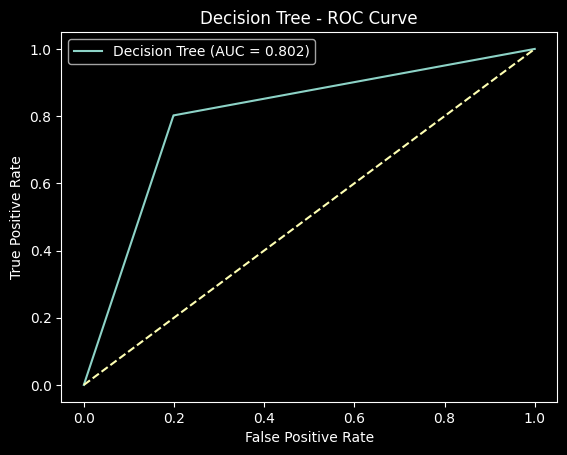

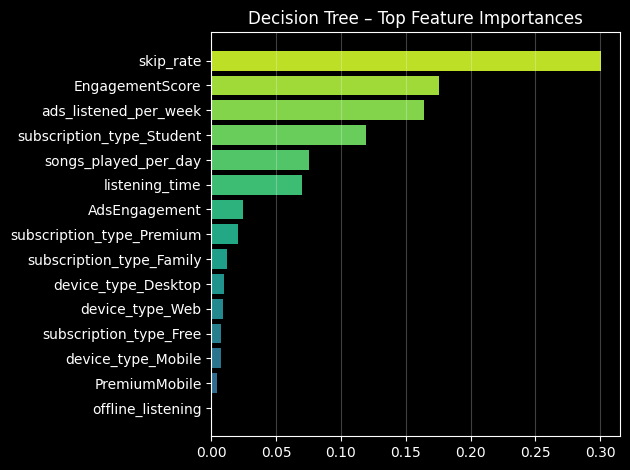

In [145]:
dt_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_results = evaluate_model("Decision Tree", dt_pipeline)

#Feature Importance
imp = (
    pd.Series(
        dt_pipeline.named_steps["model"].feature_importances_,
        index=dt_pipeline.named_steps["preprocessor"].get_feature_names_out()
    )
    .rename(lambda x: x.split("__")[-1])
    .sort_values()
    .tail(15)
)

plt.style.use("dark_background")
plt.barh(imp.index, imp.values,
         color=plt.cm.viridis(np.linspace(0.3, 0.9, len(imp))))
plt.title("Decision Tree – Top Feature Importances")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()


14.3 Random Forest


Random Forest
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       915
           1       0.88      0.91      0.89      1093

    accuracy                           0.88      2008
   macro avg       0.88      0.88      0.88      2008
weighted avg       0.88      0.88      0.88      2008



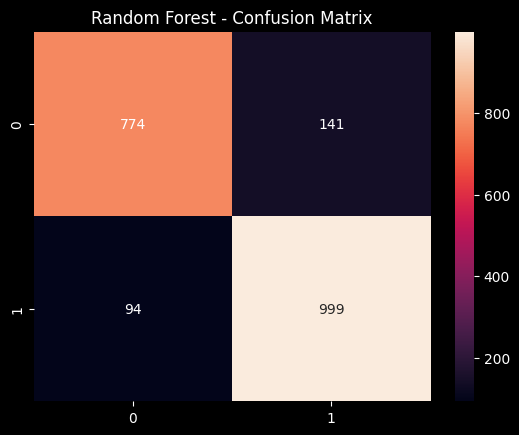

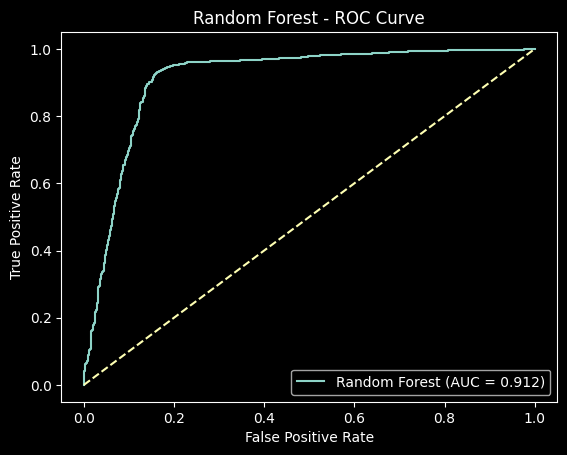

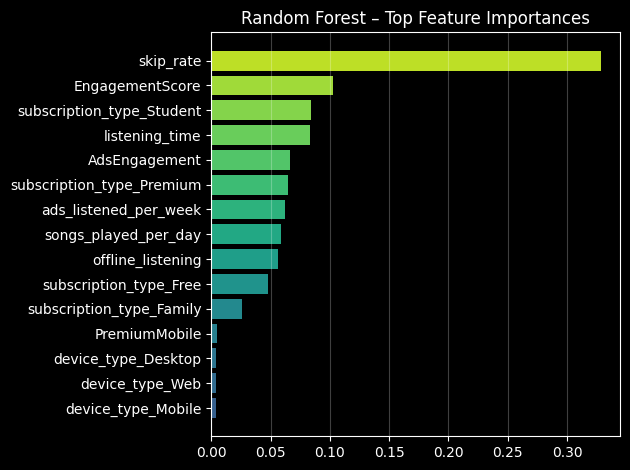

In [146]:
rf_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,          # more trees = better stability
        max_depth=18,              # controls overfitting
        min_samples_split=10,      # smoother splits
        min_samples_leaf=4,        # reduces noisy leaves
        max_features="sqrt",       # strong default for RF
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])



rf_results = evaluate_model("Random Forest", rf_pipeline)



imp = (
    pd.Series(
        rf_pipeline.named_steps["model"].feature_importances_,
        index=rf_pipeline.named_steps["preprocessor"].get_feature_names_out()
    )
    .rename(lambda x: x.split("__")[-1])
    .sort_values()
    .tail(15)
)

plt.style.use("dark_background")
plt.barh(imp.index, imp.values,
         color=plt.cm.viridis(np.linspace(0.3, 0.9, len(imp))))
plt.title("Random Forest – Top Feature Importances")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

14.4 SVM


SVM
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       915
           1       0.89      0.89      0.89      1093

    accuracy                           0.88      2008
   macro avg       0.88      0.88      0.88      2008
weighted avg       0.88      0.88      0.88      2008



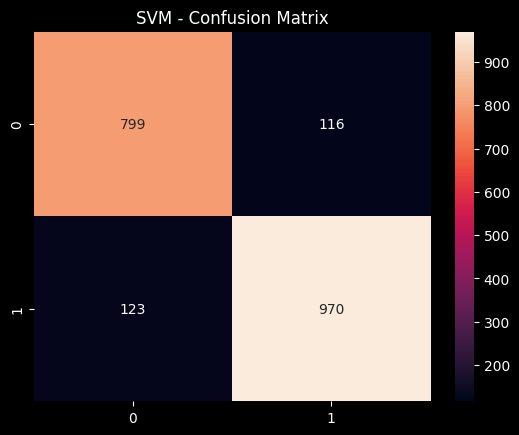

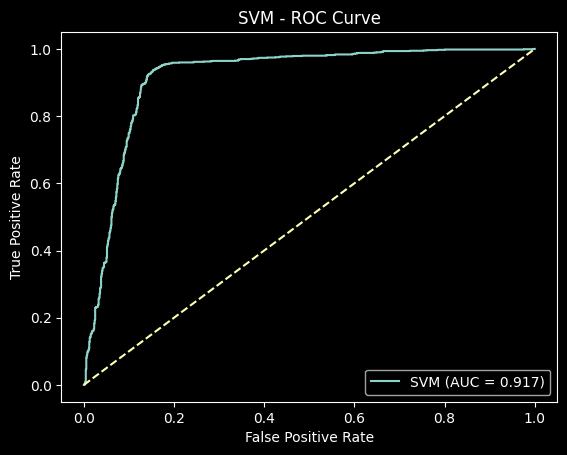

In [147]:
svm_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("model", SVC(
        kernel="linear",   # simplest kernel
        C=0.01,            # very strong regularization
        probability=True,
        random_state=42
    ))
])

svm_results = evaluate_model("SVM", svm_pipeline)


14.5 XGBoost


XGBoost
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       915
           1       0.87      0.90      0.89      1093

    accuracy                           0.87      2008
   macro avg       0.87      0.87      0.87      2008
weighted avg       0.87      0.87      0.87      2008



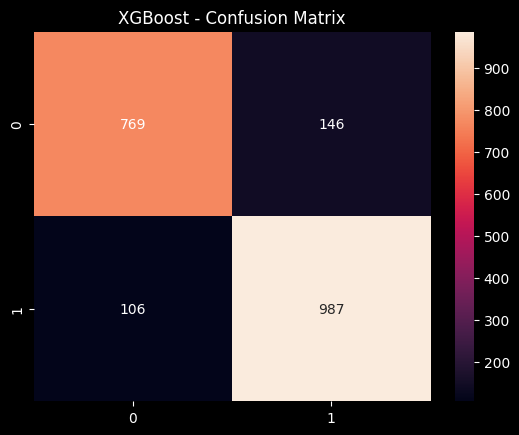

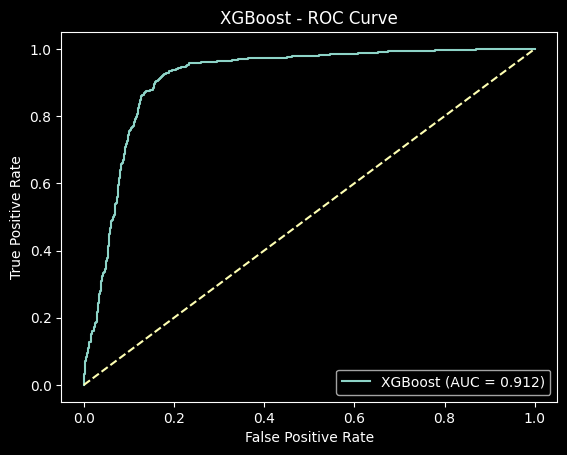

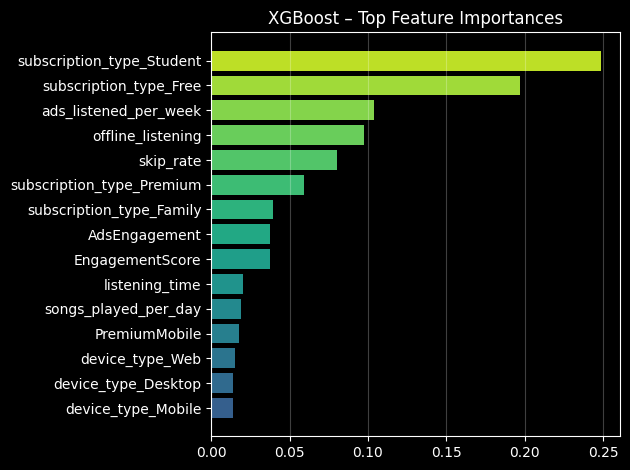

In [148]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_results = evaluate_model("XGBoost", xgb_pipeline)

#Feature Importance
imp = (
    pd.Series(
        xgb_pipeline.named_steps["model"].feature_importances_,
        index=xgb_pipeline.named_steps["preprocessor"].get_feature_names_out()
    )
    .rename(lambda x: x.split("__")[-1])
    .sort_values()
    .tail(15)
)

plt.style.use("dark_background")
plt.barh(imp.index, imp.values,
         color=plt.cm.viridis(np.linspace(0.3, 0.9, len(imp))))
plt.title("XGBoost – Top Feature Importances")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()


15. Model Comparisons and Selection

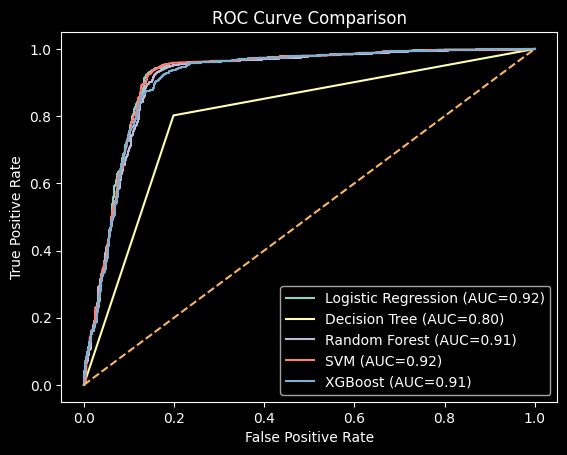

In [149]:
plt.figure()
for r in [lr_results, dt_results, rf_results, svm_results, xgb_results]:
    fpr, tpr = r["ROC"]
    plt.plot(fpr, tpr, label=f"{r['Model']} (AUC={r['ROC-AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [150]:
results_df = pd.DataFrame([
    lr_results, dt_results, rf_results, svm_results, xgb_results
]).drop(columns=["Pipeline", "ROC"])

results_df.sort_values("ROC-AUC", ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Training Time (s),Prediction Time (s),Peak Memory (MB)
0,Logistic Regression,0.870020,0.888785,0.870082,0.879334,0.916738,0.330918,0.020904,2.800329
3,SVM,0.880976,0.893186,0.887466,0.890317,0.916626,8.924709,0.621312,2.793632
4,XGBoost,0.874502,0.871139,0.903019,0.886792,0.912061,0.650251,0.054578,1.568367
2,Random Forest,0.882968,0.876316,0.913998,0.894760,0.911910,9.695462,0.398017,3.810431
1,Decision Tree,0.801793,0.828140,0.802379,0.815056,0.801628,0.402087,0.026350,2.796296


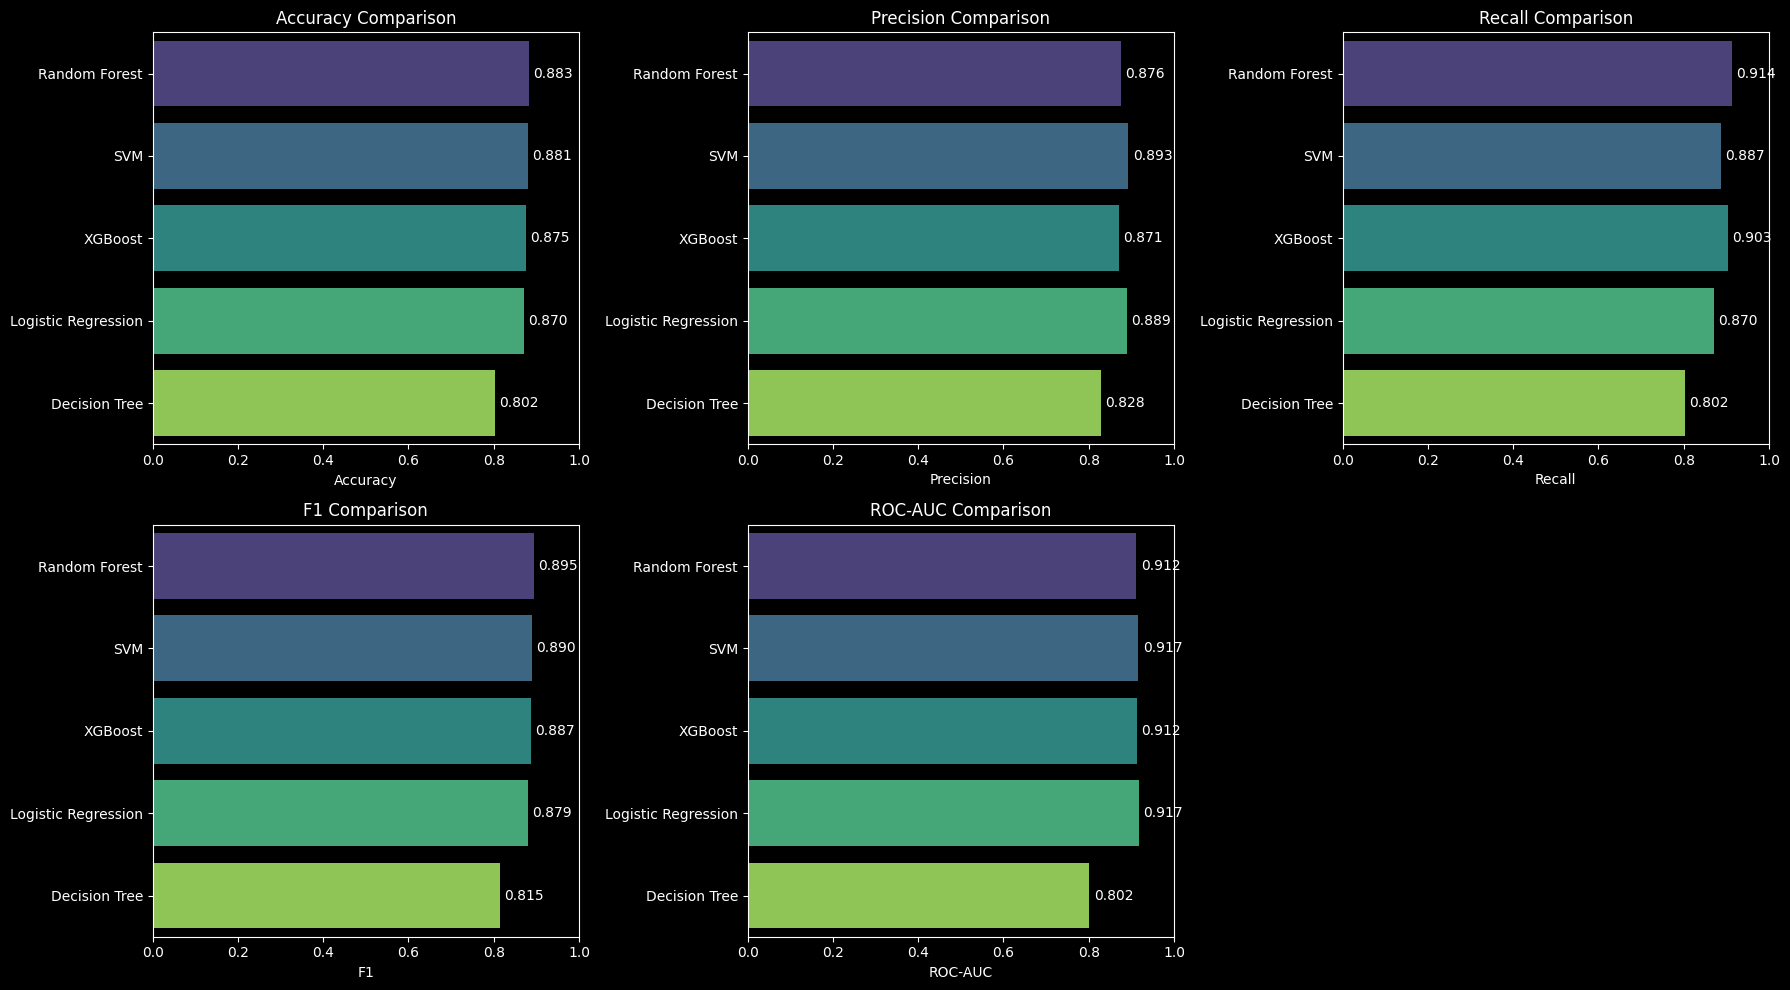

In [151]:
# Metrics to visualize
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

# Sort models by Accuracy (for consistent ordering)
df_sorted = results_df.sort_values("Accuracy", ascending=False)
# Bar Charts
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(
        x=df_sorted[metric],
        y=df_sorted["Model"],
        ax=axes[i],
        palette="viridis"
    )
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel("")

    # Value labels
    for j, value in enumerate(df_sorted[metric]):
        axes[i].text(value + 0.01, j, f"{value:.3f}", va="center")

# Remove unused subplot (bottom-right)
axes[-1].axis("off")

plt.tight_layout()
plt.show()


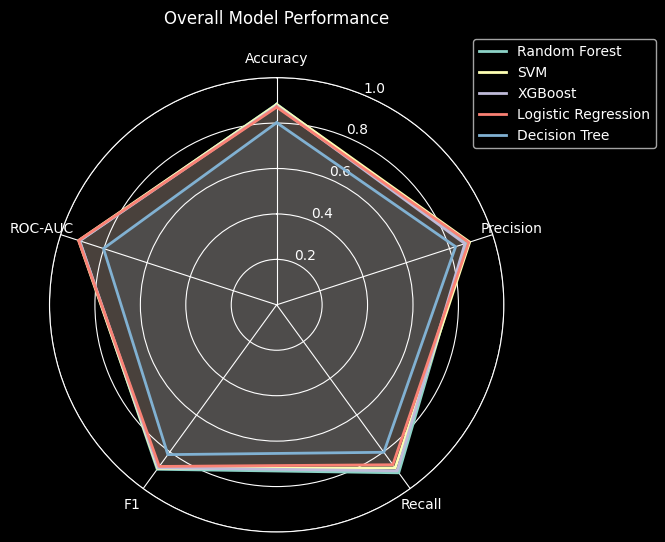

In [152]:
# Radar chart setup
labels = metrics
num_metrics = len(labels)

angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

for _, row in df_sorted.iterrows():
    values = row[metrics].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, label=row["Model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)

plt.title("Overall Model Performance", pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))
plt.tight_layout()
plt.show()


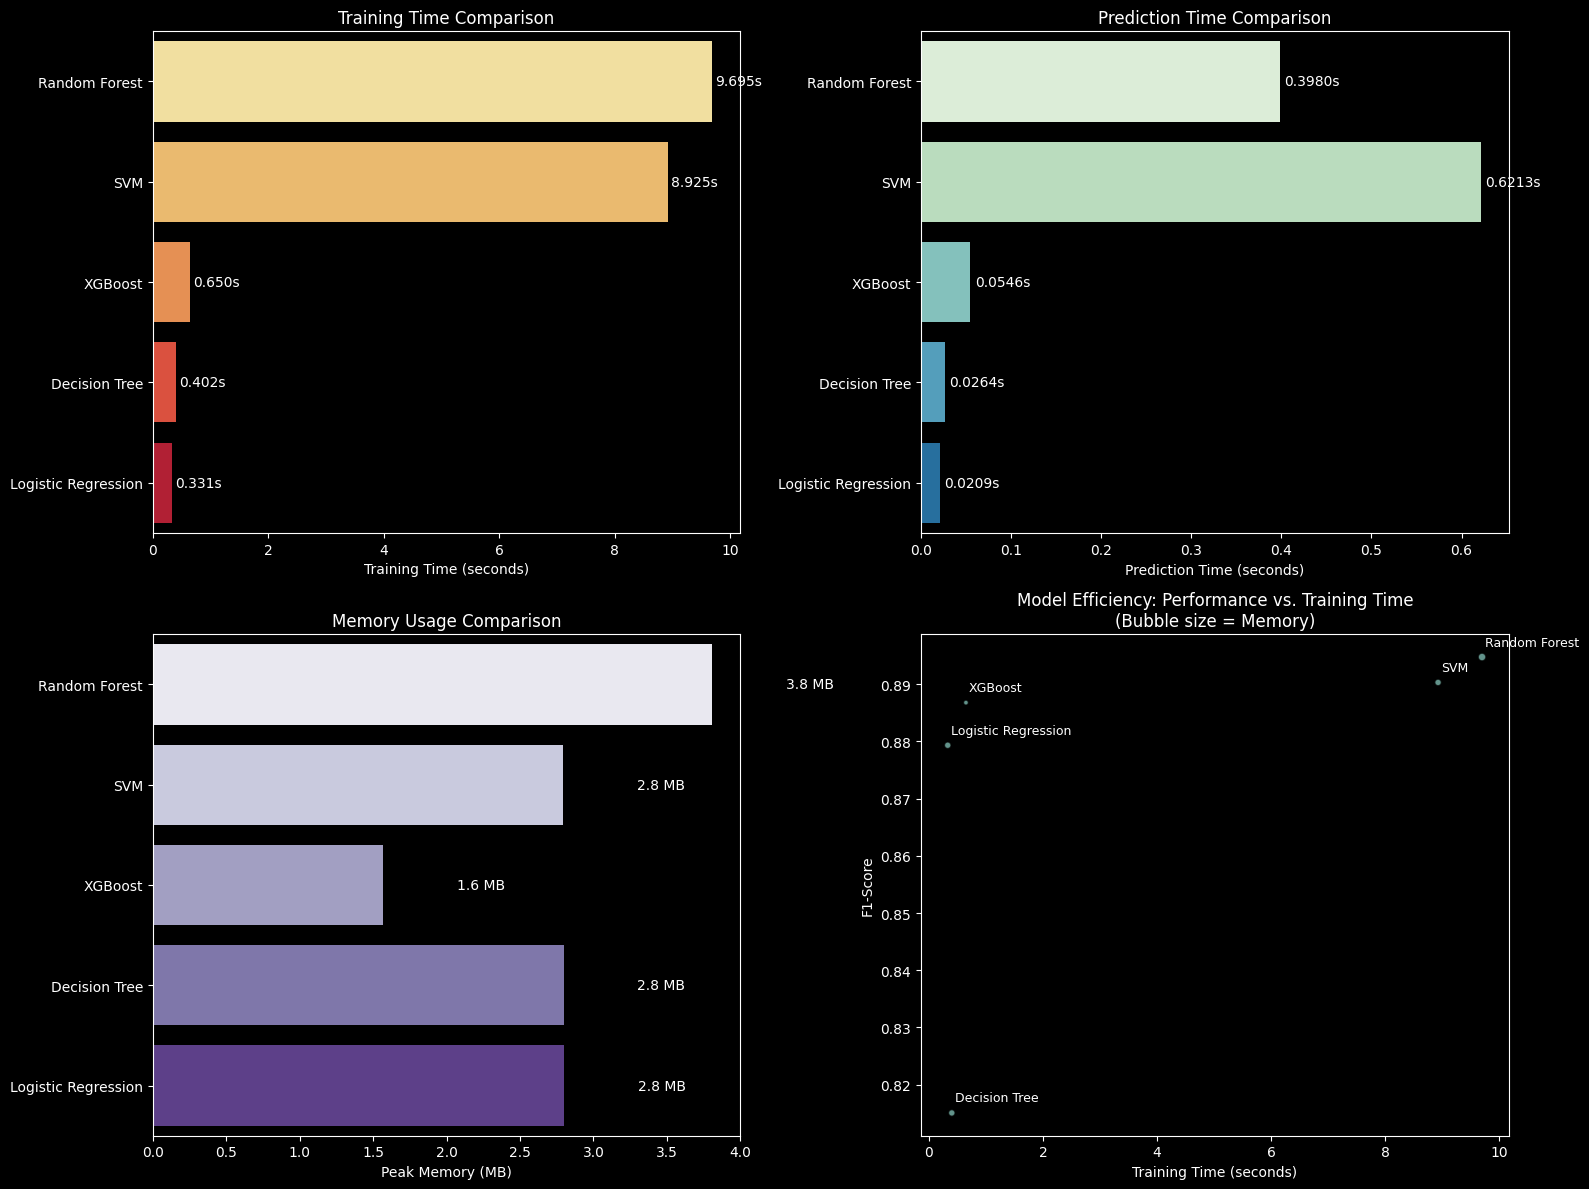

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by training time for clean visuals
df_eff = results_df.sort_values("Training Time (s)", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Training Time
sns.barplot(
    x="Training Time (s)",
    y="Model",
    data=df_eff,
    palette="YlOrRd",
    ax=axes[0, 0]
)
axes[0, 0].set_title("Training Time Comparison")
axes[0, 0].set_xlabel("Training Time (seconds)")
axes[0, 0].set_ylabel("")

for i, v in enumerate(df_eff["Training Time (s)"]):
    axes[0, 0].text(v + 0.05, i, f"{v:.3f}s", va="center")

# Prediction Time
sns.barplot(
    x="Prediction Time (s)",
    y="Model",
    data=df_eff,
    palette="GnBu",
    ax=axes[0, 1]
)
axes[0, 1].set_title("Prediction Time Comparison")
axes[0, 1].set_xlabel("Prediction Time (seconds)")
axes[0, 1].set_ylabel("")

for i, v in enumerate(df_eff["Prediction Time (s)"]):
    axes[0, 1].text(v + 0.005, i, f"{v:.4f}s", va="center")

# Memory Usage
sns.barplot(
    x="Peak Memory (MB)",
    y="Model",
    data=df_eff,
    palette="Purples",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Memory Usage Comparison")
axes[1, 0].set_xlabel("Peak Memory (MB)")
axes[1, 0].set_ylabel("")

for i, v in enumerate(df_eff["Peak Memory (MB)"]):
    axes[1, 0].text(v + 0.5, i, f"{v:.1f} MB", va="center")

# Efficiency Scatter
scatter = axes[1, 1].scatter(
    df_eff["Training Time (s)"],
    df_eff["F1"],
    s=df_eff["Peak Memory (MB)"] * 8,
    alpha=0.7,
    edgecolors="k"
)

for _, row in df_eff.iterrows():
    axes[1, 1].text(
        row["Training Time (s)"] + 0.05,
        row["F1"] + 0.002,
        row["Model"],
        fontsize=9
    )

axes[1, 1].set_title("Model Efficiency: Performance vs. Training Time\n(Bubble size = Memory)")
axes[1, 1].set_xlabel("Training Time (seconds)")
axes[1, 1].set_ylabel("F1-Score")

plt.tight_layout()
plt.show()


| Model               | Training Complexity (Approx.) | Prediction Complexity |
| ------------------- | ----------------------------- | --------------------- |
| Logistic Regression | O(n · d · i)                  | O(d)                  |
| Decision Tree       | O(n · d · log n)              | O(log n)              |
| Random Forest       | O(t · n · d · log n)          | O(t · log n)          |
| SVM (Linear)        | O(n · d)                      | O(d)                  |
| XGBoost             | O(t · n · d)                  | O(t · d)              |


In [154]:
best_pipeline = rf_pipeline
best_pipeline.fit(X_train, y_train)
import joblib

joblib.dump(
    best_pipeline,
    "spotify_churn_random_forest.pkl"
)


['spotify_churn_random_forest.pkl']

16. Fairness check

In [155]:
def fairness_by_group(model, X_test, y_test, group_series, group_name):
    results = []

    for group in group_series.unique():
        idx = group_series == group

        y_true = y_test[idx]
        y_pred = model.predict(X_test[idx])

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0

        results.append({
            "Group": group,
            "Recall (TPR)": recall,
            "False Negative Rate": fnr,
            "Support": len(y_true)
        })

    return pd.DataFrame(results).set_index("Group")

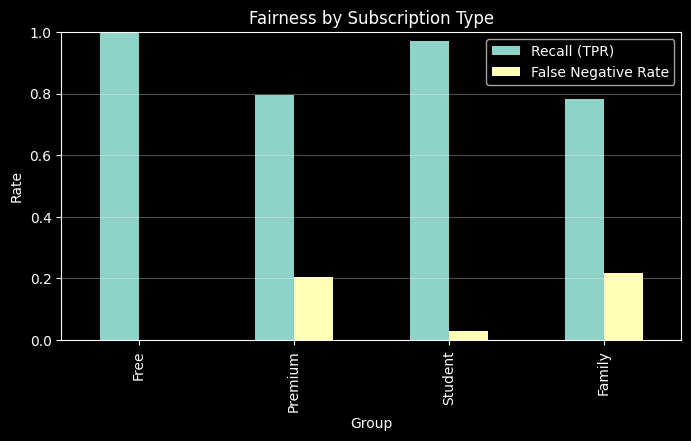

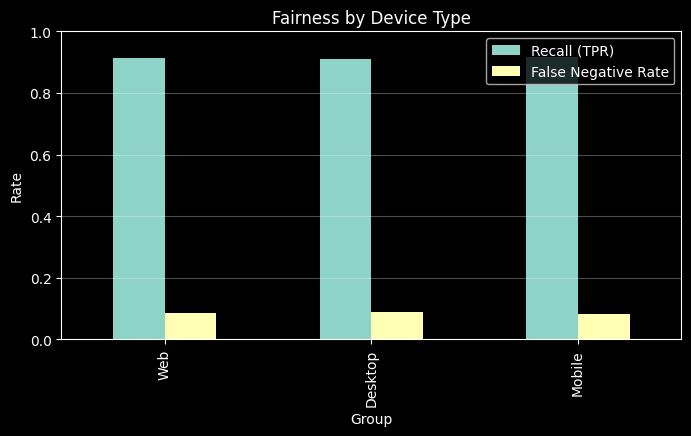

In [156]:
best_model = best_pipeline

# Fairness across subscription type
fairness_subscription = fairness_by_group(
    best_model,
    X_test,
    y_test,
    X_test["subscription_type"],
    "subscription_type"
)

# Fairness across device type
fairness_device = fairness_by_group(
    best_model,
    X_test,
    y_test,
    X_test["device_type"],
    "device_type"
)

fairness_subscription, fairness_device

def plot_fairness(df, title):
    df[["Recall (TPR)", "False Negative Rate"]].plot(
        kind="bar",
        figsize=(8, 4)
    )
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel("Rate")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

plot_fairness(fairness_subscription, "Fairness by Subscription Type")
plot_fairness(fairness_device, "Fairness by Device Type")
